In [2]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch
import numpy as np
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss
from typing import Literal
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles
import matplotlib.pyplot as plt
from awesome.run.functions import get_mpl_figure, plot_mask, prepare_input_eval
from awesome.util.matplotlib import saveable
from typing import Optional, Tuple
from typing import Any, Dict
from awesome.analytics.result_model import ResultModel
from awesome.util.temporary_property import TemporaryProperty
from awesome.model.path_connected_net import PathConnectedNet, minmax
from matplotlib.axes import Axes

basic_config()
os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

D:\projects\AWESOME\awesome\agent\torch_agent.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [20]:
save_dir = "output/fbms_qualitative_results"
os.makedirs(save_dir, exist_ok=True)

def get_runner_result(result_model: ResultModel, 
                      checkpoint_index: int, 
                      image_index: int) -> Tuple[Dict[str, Any], AwesomeRunner, AwesomeDataset, torch.nn.Module]:

    runner = result_model.get_runner(checkpoint_index)

    model = runner.agent._get_model()
    dataloader = runner.agent.training_dataset
    model_gets_targets = runner.agent.model_gets_targets

    res, ground_truth, img, fg, bg = get_result(model, dataloader, image_index, model_gets_targets=model_gets_targets)
    res = split_model_result(res, model, dataloader, img)

    with torch.no_grad(), TemporaryProperty(dataloader, do_image_blurring=False, image_channel_format="rgb"):
        image_no_blur = prepare_input_eval(dataloader, model, image_index)[0]

    res['image'] = img
    res['image_index'] = image_index
    res['image_no_blur'] = image_no_blur

    res['ground_truth'] = ground_truth
    res['foreground'] = fg
    res['background'] = bg

    return res, runner, dataloader, model

@saveable()
def plot(res, size:float = 5, 
         darkening_background: float = 0, 
         legend: bool = True,
         **kwargs):
    import matplotlib.patches as mpatches


    # fig = plot_image_scribbles(image=res.get('image_no_blur'),
    #                             inference_result=res.get('segmentation'),
    #                             foreground_mask=res.get('foreground'),
    #                             background_mask=res.get('background'),
    #                             prior_result=res.get('prior'),
    #                             size=10,
    #                             save=True,
    #                             ext=["pdf", "png"],
    #                             path=os.path.join(folder, f"{file_name_prefix}_{dataset_name}_{res.get('image_index')}_ep{tracker.training_epoch}_legend"),
    #                             tight=True,
    #                             legend=True,
    #                             override=True,
    #                             legend_label_mapping=label_names,
    #                             )

    color_gt = plt.get_cmap("tab10")(3)
    

    gt_mask = 1 - res.get("ground_truth")

    fig = plot_mask(res.get('image_no_blur'), 
                    gt_mask,
                    size=size,
                    tight=True,
                    color=color_gt,
                    filled_contours=True,
    )

    masks = torch.cat([1 - res.get("segmentation"), 1 - res.get("prior")], dim=0)

    fig = plot_mask(None, 
                    masks,
                    ax=fig.axes[0],
                    darkening_background=0,
                    #filled_contours=True,
        )
    
    if darkening_background > 0:
        all_masks = torch.cat([masks[0].unsqueeze(0), masks[1].unsqueeze(0), gt_mask], dim=0)
        background_mask = all_masks.sum(dim=0) == 0
        fig.axes[0].imshow(background_mask, cmap='alpha_binary', alpha=darkening_background, label='')
    
    
    if legend:
        patches = []

        colors = [plt.get_cmap("tab10")(0), plt.get_cmap("tab10")(1), color_gt]
        labels = ["UNet", "PC Prior", "Ground Truth"]

        patches = [mpatches.Patch(color=m, label=n) for m, n in zip(colors, labels)]
        fig.axes[0].legend(handles=patches, loc="upper right", bbox_to_anchor=(1.0, 1.0), framealpha=1.0, frameon=True, edgecolor="black")

    return fig

def plot_pre_post(result_model, indices, save_dir, display: bool = True, legend: bool = True):
   
   dataset_name = result_model.get_runner(0).dataloader.__dataset__.dataset_name
   save_dir = os.path.join(save_dir, dataset_name)

   accuracy_text = ""

   for index in indices:
      res_pre, runner_pre, dataloader_pre, model_pre = get_runner_result(result_model, 0, index)
      res_post, runner_post, dataloader_post, model_post = get_runner_result(result_model, -1, index)

      post_fix = "_legend" if legend else ""

      pre_path=os.path.join(save_dir, f"pre_{dataset_name}_{index}_ep{runner_pre.agent.tracker.training_epoch}{post_fix}")
      post_path=os.path.join(save_dir, f"post_{dataset_name}_{index}_ep{runner_post.agent.tracker.training_epoch}{post_fix}")

      gt_indices =  dataloader_pre.__dataset__.get_ground_truth_indices()

      metrics = ["eval/epoch/ForegroundBinaryMIOU", "eval/epoch/PriorForegroundBinaryMIOU"]

      gt_index = gt_indices.index(index)

      seg_ious = runner_post.agent.tracker.metrics[metrics[0]].values
      prior_ious = runner_post.agent.tracker.metrics[metrics[1]].values

      seg_iou_pre = seg_ious.iloc[0]["value"][gt_index]
      prior_iou_pre = prior_ious.iloc[0]["value"][gt_index]

      seg_iou_post = seg_ious.iloc[-1]["value"][gt_index]
      prior_iou_post = prior_ious.iloc[-1]["value"][gt_index]

      accuracy_text += str(index) + ":\n" + f"Segmentation IOU pre: {seg_iou_pre} post: {seg_iou_post}\n Prior IOU pre: {prior_iou_pre} post: {prior_iou_post}\n"

      print(f"Segmentation IOU pre: {seg_iou_pre} post: {seg_iou_post}")
      print(f"Prior IOU pre: {prior_iou_pre} post: {prior_iou_post}")

      plot(res_pre,
         save=True,
            ext=["pdf", "png"],
            size=3,
            darkening_background=0.7,
            path=pre_path,
            override=True,
            display=display,
            auto_close=True,
            legend=legend,
         )
      

      plot(res_post, 
         save=True,
         darkening_background=0.7,
         size=3,
            ext=["pdf", "png"],
            path=post_path,
            override=True,
            display=display,
            auto_close=True,
            legend=legend,
            )
      
   accuracy_text_path=os.path.join(save_dir, f"measures_{dataset_name}.txt")
   with open(accuracy_text_path, "w") as f:
      f.write(accuracy_text)


In [27]:
save_dir

'output/fbms_qualitative_results'

In [22]:


path = "./runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#11_UNET+cats05+edge+diffeo+original+joint_24_01_11_17_06_14"

result_model = ResultModel.from_path(path)

index = result_model.get_runner(0).dataloader.__dataset__.get_ground_truth_indices()

indices = index if isinstance(index, list) else [index]

#plot_pre_post(result_model, indices, save_dir, display=True, legend=True)
plot_pre_post(result_model, indices, save_dir, display=False, legend=False)

2024-02-02:02:02:38.633 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#11_UNET+cats05+edge+diffeo+original+joint_24_01_11_17_06_14
2024-02-02:02:02:41.208 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!
2024-02-02:02:02:42.077 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#11_UNET+cats05+edge+diffeo+original+joint_24_01_11_17_06_14
2024-02-02:02:02:44.050 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


Segmentation IOU pre: 0.5719277262687683 post: 0.023503851145505905
Prior IOU pre: 0.5236164331436157 post: 0.5589273571968079
Segmentation IOU pre: 0.7384976744651794 post: 0.41901251673698425
Prior IOU pre: 0.7226535081863403 post: 0.7045081853866577
Segmentation IOU pre: 0.6226884722709656 post: 0.5393350124359131
Prior IOU pre: 0.5783666372299194 post: 0.5817137360572815
Segmentation IOU pre: 0.6752409934997559 post: 0.7195171117782593
Prior IOU pre: 0.6524744033813477 post: 0.6453373432159424
Segmentation IOU pre: 0.5079345107078552 post: 0.45240771770477295
Prior IOU pre: 0.46195876598358154 post: 0.4116775095462799
Segmentation IOU pre: 0.52540123462677 post: 0.36618801951408386
Prior IOU pre: 0.5167389512062073 post: 0.37654390931129456


In [21]:


path = "runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14"

result_model = ResultModel.from_path(path)

index = result_model.get_runner(0).dataloader.__dataset__.get_ground_truth_indices()

indices = index if isinstance(index, list) else [index]

#plot_pre_post(result_model, indices, save_dir, display=False, legend=True)
plot_pre_post(result_model, indices, save_dir, display=False, legend=False)

2024-02-02:01:56:28.703 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14
2024-02-02:01:56:29.267 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!
2024-02-02:01:56:30.175 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14
2024-02-02:01:56:30.771 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


Segmentation IOU pre: 0.839735209941864 post: 0.8391851186752319
Prior IOU pre: 0.8401133418083191 post: 0.8548014163970947
Segmentation IOU pre: 0.8524139523506165 post: 0.9278128147125244
Prior IOU pre: 0.9196251630783081 post: 0.9247809648513794
Segmentation IOU pre: 0.6451694965362549 post: 0.8954976797103882
Prior IOU pre: 0.8822349905967712 post: 0.8850025534629822


2024-01-22:10:52:49.256 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14
2024-01-22:10:52:49.844 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!
D:\projects\AWESOME\awesome\dataset\fbms_sequence_dataset.py:756: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  bg_flip_coords = flip_probability[torch.argwhere(bg_flip_mask).squeeze(), :2].int().T
2024-01-22:10:52:50.699 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp

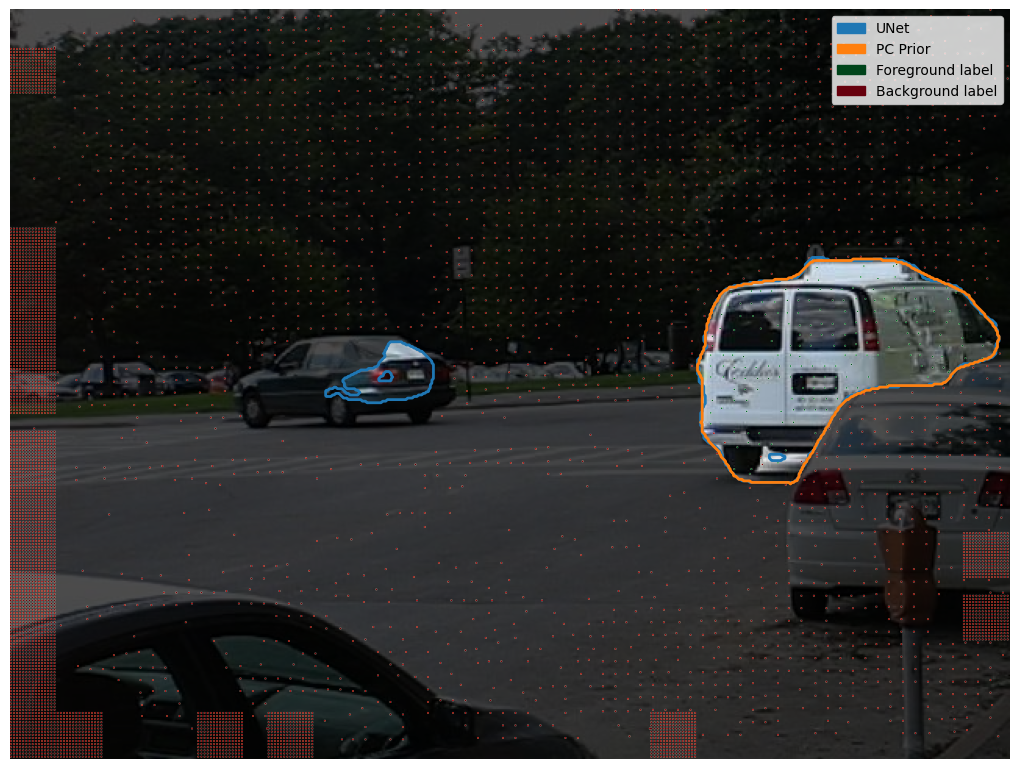

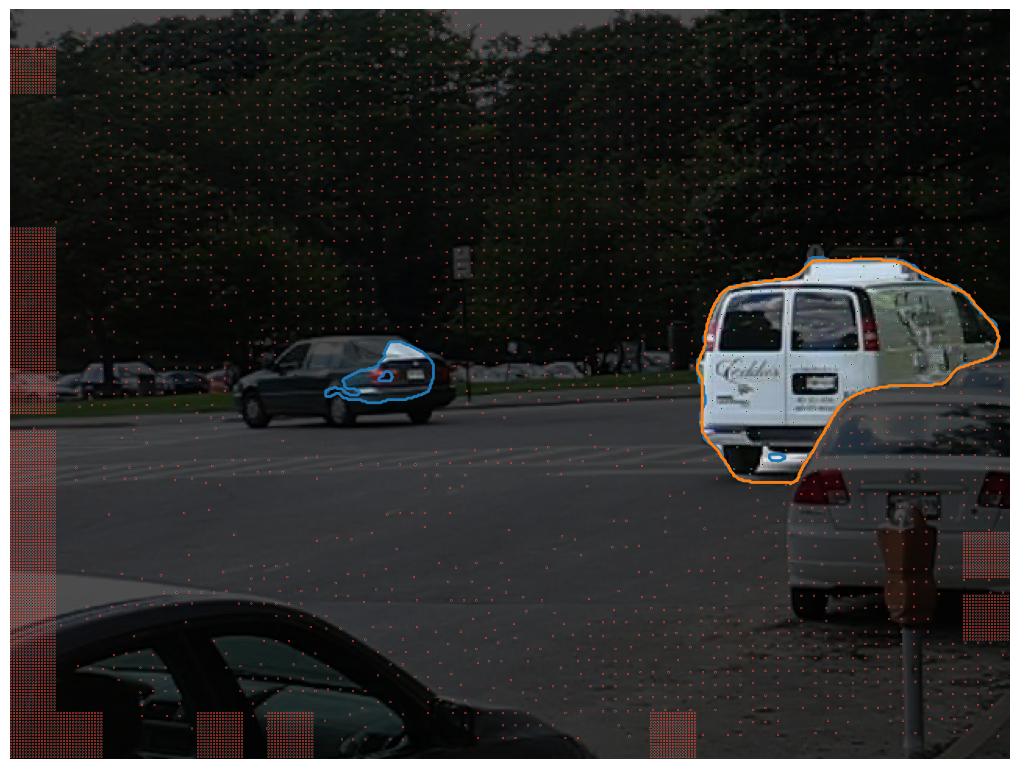

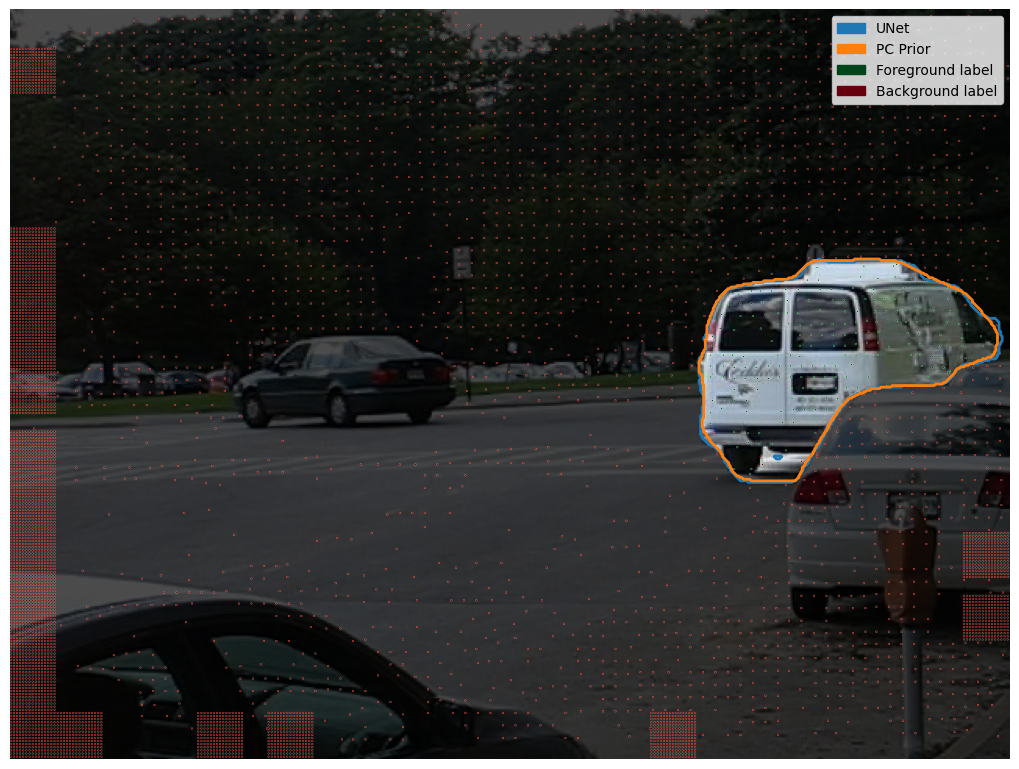

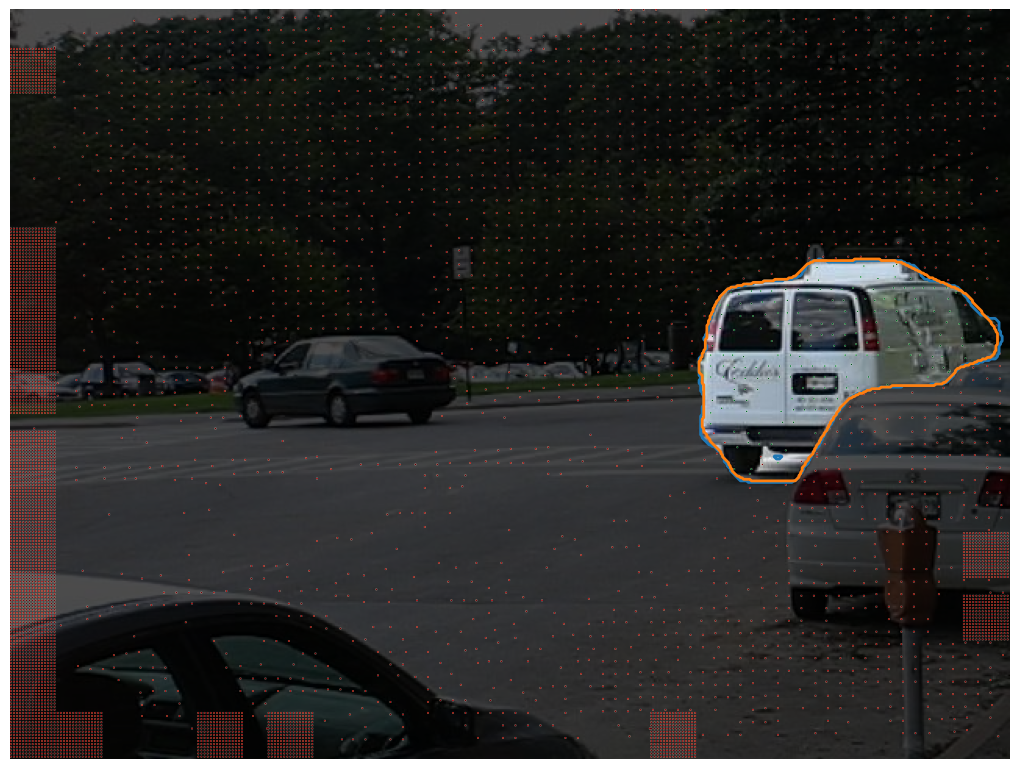

In [50]:


path = "runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14"
index = 10

result_model = ResultModel.from_path(path)

res_pre, runner_pre, dataloader_pre, model_pre = get_runner_result(result_model, 0, index)
res_post, runner_post, dataloader_post, model_post = get_runner_result(result_model, -1, index)

plot(res_pre, dataloader_pre, runner_pre.agent.tracker, save_dir, 'pre')
plot(res_post, dataloader_post, runner_post.agent.tracker, save_dir, 'post')
